# Introduction to Artificial Intelligence: HS 2023


---

## Lecture 11: Deep Learning for Computer Vision


In this demo, we will get hands-on experiences on Convolutional Neural Networks using LeNet's model trained on the MNIST dataset.


## Project: Pytorch implementation

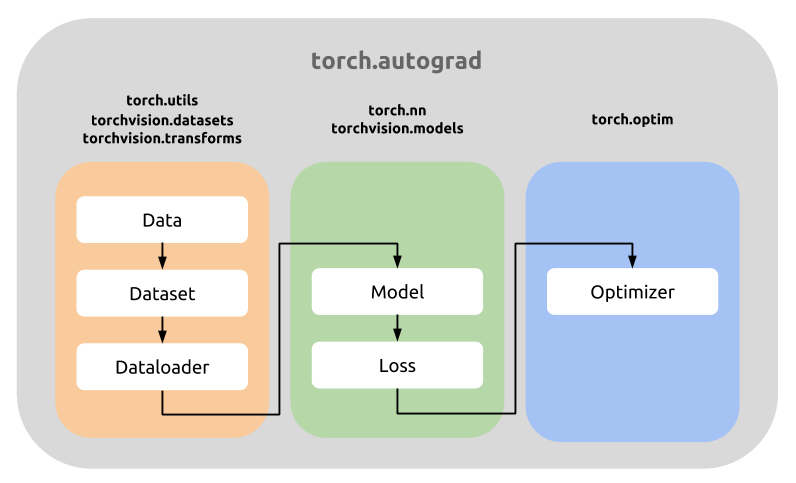
<center> Figure. PyTorch Training Overview </center>

### MNIST classification with LeNet-5

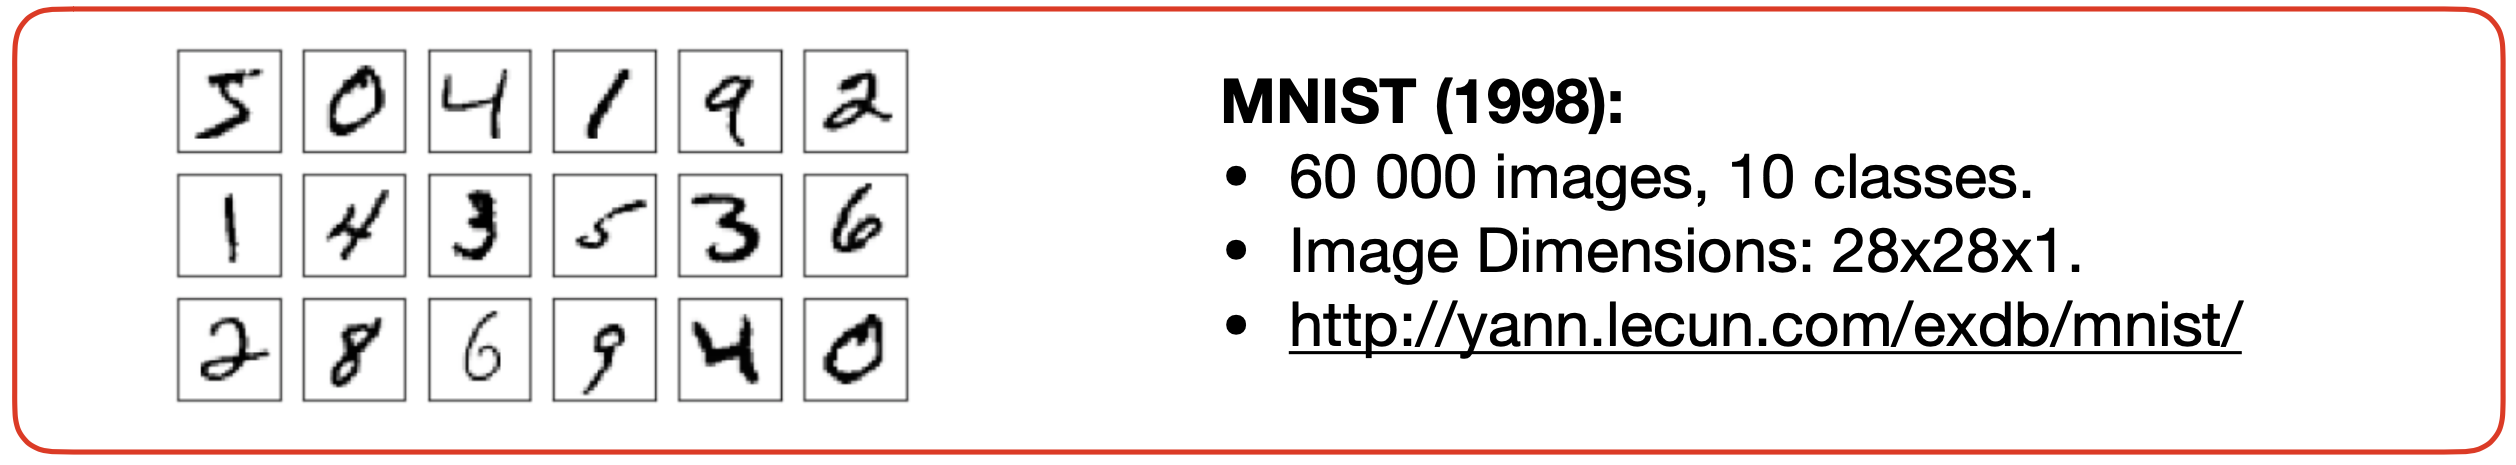
<center> Figure. MNIST Handwritten digits dataset </center>

In [ ]:
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import time
import numpy as np
import torch.nn.functional as F
import torch
import torch.nn as nn
import scikitplot as skplt
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import os as os

from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import confusion_matrix

#### General settings

In [ ]:
#@title Fill Code

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Hyperparameters
random_seed = 1
learning_rate = 0.001
num_epochs = 10

# Architecture
num_classes = ...

dataset_dir = 'data'

num_threads = 4     # Loading the dataset is using 4 CPU threads
batch_size  = ...   # Using minibatches of 32 samples

In [ ]:
#@title Solution

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Hyperparameters
random_seed = 1
learning_rate = 0.001
num_epochs = 10

# Architecture
num_classes = 10

dataset_dir = 'data'

num_threads = 4     # Loading the dataset is using 4 CPU threads
batch_size  = 32   # Using minibatches of 128 samples

#### Dataset
In this example, we will use the standard [MNIST](http://yann.lecun.com/exdb/mnist/) dataset.
The MNIST dataset contains of handwritten digits (i.e. 0 to 9) and is used in image classification.


In [ ]:
#@title Fill Code

valid_ratio = 0.2  # We will  use 80%/20% split for train/valid

resize_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])


# Load the training dataset for the training/validation sets. Hint: have a look at datasets from torchvision
# Note transforms.ToTensor() scales input images to 0-1 range
train_valid_dataset = ...

# 60K images of 28x28 pixels

# Split it into training and validation sets
nb_train = int((1.0 - valid_ratio) * len(train_valid_dataset))
nb_valid =  int(valid_ratio * len(train_valid_dataset))
train_dataset, valid_dataset = torch.utils.data.dataset.random_split(train_valid_dataset, [nb_train, nb_valid])

100%|██████████| 9912422/9912422 [00:00<00:00, 272955160.91it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 96676531.38it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 77730225.99it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 11630359.44it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
#@title Solution

valid_ratio = 0.2  # Going to use 80%/20% split for train/valid

resize_transform = transforms.Compose([transforms.Resize((32, 32)),
                                       transforms.ToTensor()])


# Load the dataset for the training/validation sets
# Note transforms.ToTensor() scales input images
# to 0-1 range
train_valid_dataset = datasets.MNIST(root=dataset_dir,
                                           train=True,
                                           transform=resize_transform, # [0,255]->[0,1]
                                           download=True)
# 60K images of 28x28 pixels

# Split it into training and validation sets
nb_train = int((1.0 - valid_ratio) * len(train_valid_dataset))
nb_valid =  int(valid_ratio * len(train_valid_dataset))
train_dataset, valid_dataset = torch.utils.data.dataset.random_split(train_valid_dataset, [nb_train, nb_valid])

In [ ]:
#@title Fill Code


# Load the test dataset for the training/validation sets. Hint: have a look at datasets from torchvision
# Note transforms.ToTensor() scales input images to 0-1 range

test_dataset = ...

In [ ]:
#@title Solution


test_dataset = datasets.MNIST(root=dataset_dir,
                              train=False,
                              transform=resize_transform) # [0,255]->[0,1]

##### Loading Dataset
**Note**: We shuffle the loading process of `train_dataset` to make the learning process independent of data order, but the order of `test_loader` remains so as to examine whether we can handle unspecified bias order of inputs.

In [ ]:
#@title Fill Code

# For each dataset, initialise a DataLoader() object, which will help you to get your batches, while training your model
train_loader = ...
valid_loader = ...
test_loader = ...

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
#@title Solution

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=num_threads)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=batch_size,
                          shuffle=False,
                          num_workers=num_threads)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=False)

In [ ]:
print("The train set contains {} images, in {} batches".format(len(train_loader.dataset), len(train_loader)))
print("The validation set contains {} images, in {} batches".format(len(valid_loader.dataset), len(valid_loader)))
print("The test set contains {} images, in {} batches".format(len(test_loader.dataset), len(test_loader)))

The train set contains 48000 images, in 1500 batches
The validation set contains 12000 images, in 375 batches
The test set contains 10000 images, in 313 batches


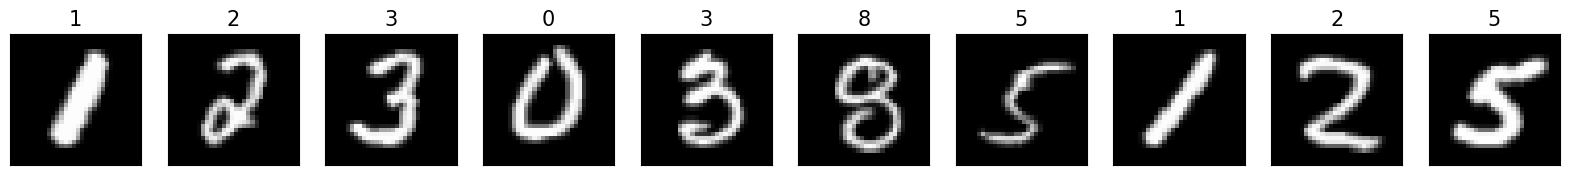

In [ ]:
nsamples = 10
classes_names = ['0', '1', '2', '3', '4', '5','6', '7', '8', '9']
imgs, labels = next(iter(train_loader))

fig=plt.figure(figsize=(20,5),facecolor='w')
for i in range(nsamples):
    ax = plt.subplot(1,nsamples, i+1)
    plt.imshow(imgs[i, 0, :, :], vmin=0, vmax=1.0, cmap=cm.gray)
    ax.set_title("{}".format(classes_names[labels[i]]), fontsize=15)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In order to create the LeNet5, we are going to use:
*   the [Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) layer
*   the [nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) convolutional operator and
*   the [MaxPool2d](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) operator
of PyTorch.

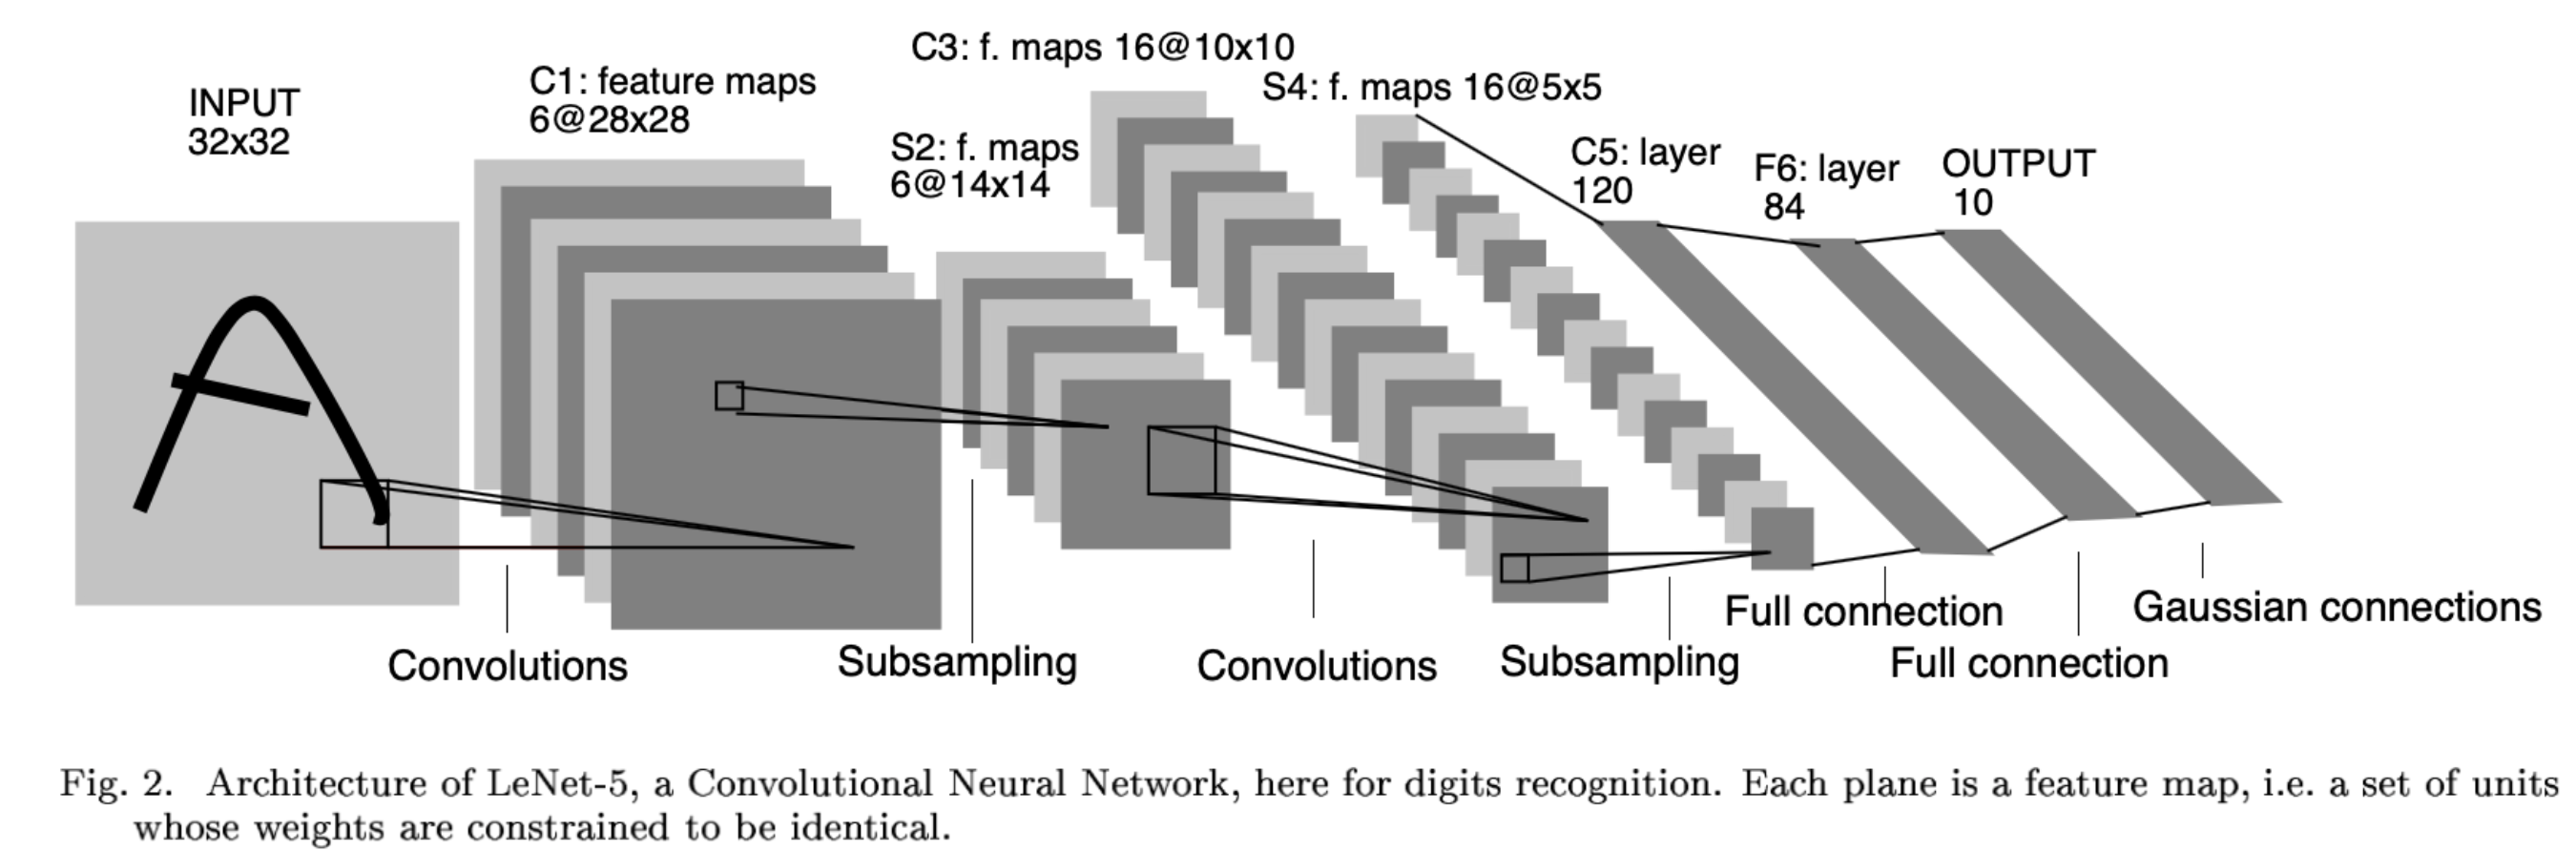

In [ ]:
#@title Fill Code

class LeNet5(nn.Module):

    def __init__(self, num_classes, in_channels=1):
        super(LeNet5, self).__init__()

        self.num_classes = num_classes
        self.in_channels = in_channels

        self.features = nn.Sequential(
            ... # Conv2d, kernel_size=5, 6 filters
            ... # Tanh
            ... # MaxPool2

            ... # Conv2d kernel_size=5, 16 filters
            ... # Tanh
            ... # MaxPool2
        )

        self.classifier = nn.Sequential(
            ... # Linear Layer, in=400 (16*5*5), out 120
            ... # Tanh

            ... # Linear Layer, in=120, out 84
            ... # Tanh

            ... # Linear Layer, in=84, out 10
        )


    def forward(self, x):
        x = ... # forward propagation on the convolutional layers
        x = ... # flatten the last features before MLP
        logits = ... # call MLP classifier
        probas = ... # perform softmax
        return logits, probas

In [ ]:
#@title Solution

class LeNet5(nn.Module):

    def __init__(self, num_classes, in_channels=1):
        super(LeNet5, self).__init__()

        self.num_classes = num_classes
        self.in_channels = in_channels

        self.features = nn.Sequential(
            nn.Conv2d(in_channels, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=16*5*5, out_features=120),
            nn.Tanh(),

            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),

            nn.Linear(in_features=84, out_features=num_classes),
        )


    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas

In [ ]:
#@title Fill Code

model = ... # initialise your model and put it onto the GPU memory
print(model)

In [ ]:
#@title Solution

model = LeNet5(num_classes=num_classes).to(device)
print(model)

In [ ]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(num_params)

61706


##### Loss function
Pytorch provides the
[torch.nn.CrossEntropyLoss()](https://pytorch.org/docs/stable/nn.html#torch.nn.CrossEntropyLoss)
loss function that computes the softmax followed by the cross entropy.

Consider a 3-class problem. Let us take
an input, of true class y=1, being assigned the scores
$\hat{z} = [-100, 10, 8]$, i.e. the assigned probabilities being
$\hat{y} = [\frac{\exp(-100)}{\sum_i \exp(y_i)}, \frac{\exp(10)}{\sum_i \exp(y_i)}, \frac{\exp(8)}{\sum_i \exp(y_i)}] = [0.0000, 0.8808, 0.1192]$
the cross entropy loss is given by $-\sum_{i=0}^{3} \log(\hat{y}_y) = -\log(0.8808) \approx 0.1269$
and is computed in Pytorch as :

``` {.sourceCode .python}
f_loss = torch.nn.CrossEntropyLoss()
f_loss(torch.Tensor([[-100, 10, 8]]), torch.LongTensor([1]))
# This prints :   torch.Tensor(0.1269)
```

For now, back to our experiment, we just need to instantiate the loss :

``` {.sourceCode .python}
f_loss = torch.nn.CrossEntropyLoss()
```

Alternatively, you can use the [F.nll_loss](https://pytorch.org/docs/stable/nn.functional.html#nll-loss) function and pass as parameter the result of having applied the `F.log_softmax( )` to your inputs.

In [ ]:
#@title Fill Code

loss_func = ...

In [ ]:
#@title Solution

loss_func = torch.nn.CrossEntropyLoss()

##### Optimizer
In order to update the model parameters using the computed gradients (`backward()`), we need  to define an optimizer which as its names says, it optimizes the parameters of a neural network is
performed by some kind of gradient descent. In PyTorch there are different optimizers
provided in the [torch.optim
package](https://pytorch.org/docs/stable/optim.html). We will focus on the [SGD
optimizer](https://pytorch.org/docs/stable/optim.html#torch.optim.sgd) and on the
[Adam
optimizer](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam), which are two of the most common and stable optimizers. For that purposes, the optimizer needs a reference to the parameters that it needs
to modify.

```
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
```

```
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
```

In [ ]:
#@title Fill Code

optimizer = ...

In [ ]:
#@title Solution

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

##### Train
Training a neural network involves iterating over the mini-batches of the training set and, for each mini-batch, computing the forward- and backward- propagations to provide the optimizer the gradient from which it can update the model parameters.


- Learning Process:
    1. Put inputs/labels into GPU device.
    2. Do forward propagation => Predictions
    3. Compute Loss function
    4. Do backward propagation => Gradients w.r.t. parameters
    5. Update parameters using gradients
        - `parameters = parameters - learning_rate * parameters_gradients`
    6. REPEAT learning process

In [ ]:
#@title Fill Code

def compute_accuracy_and_loss(model, data_loader, device):

    correct_pred, num_examples = 0, 0

    cross_entropy = 0.

    for ii, (features, targets) in enumerate(data_loader):

        features = ...  # [32,28,28]->[128,784]
        targets = ... # y

        logits, probas = ... # forward propagation z=logits, a=f(z)
        cross_entropy += ...

        _, predicted_labels = ... # y_hat=predicted_labels
        num_examples += targets.size(0)

        correct_pred += (predicted_labels == targets).sum()

    return correct_pred.float()/num_examples * 100, cross_entropy/num_examples

In [ ]:
#@title Solution

def compute_accuracy_and_loss(model, data_loader, device):

    correct_pred, num_examples = 0, 0

    cross_entropy = 0.

    for ii, (features, targets) in enumerate(data_loader):

        features = features.to(device) # [32,28,28]->[128,784]
        targets = targets.to(device) # y

        logits, probas = model(features) # forward propagation z=logits, a=f(z)
        cross_entropy += F.cross_entropy(logits, targets).item()
        #cross_entropy += F.nll_loss(torch.log(probas), targets)

        _, predicted_labels = torch.max(probas, 1) # y_hat=predicted_labels
        num_examples += targets.size(0)

        correct_pred += (predicted_labels == targets).sum()

    return correct_pred.float()/num_examples * 100, cross_entropy/num_examples

In [ ]:
device

device(type='cuda', index=0)

In [ ]:
#@title Fill Code

def train(model, num_epochs, train_loader, valid_loader):

  minibatch_cost = []
  train_acc_lst, valid_acc_lst = [], []
  train_loss_lst, valid_loss_lst = [], []

  best_acc = 0
  best_loss = np.inf

  start_time = time.time()
  for epoch in range(num_epochs):

      model.train()

      for batch_idx, (features, targets) in enumerate(train_loader):

          features = ... # [128,28,28] => [128,784]
          targets = ... # [128]

          # forward-propagation
          ..., ... = ...

          # compute cost function
          cost = ...

          # clean gradients
          ...

          # compute derivatives
          ...

          # append minibatch cost
          minibatch_cost.append(cost.item())

          # update model parameters
          ... # w = w - learning_rate * partial_deriv_error

          # logging results
          if not batch_idx % 50:
              print ('Epoch: %05d/%05d | Batch %05d/%05d | Cost: %.4f'
                    %(epoch+1, num_epochs, batch_idx,
                      len(train_loader), cost))

      with torch.set_grad_enabled(False):
          train_acc, train_loss = ... # get accuracy on the training dataset
          valid_acc, valid_loss = ... # get accuracy on the validation dataset

          print('Epoch: %05d/%05d | Train cost: %.4f | Valid cost: %.4f | Train acc.: %.4f%% | Val.acc.: %.4f%%' % (
                epoch+1, num_epochs,
                train_loss,
                valid_loss,
                train_acc,
                valid_acc))

          train_acc_lst.append(train_acc)
          valid_acc_lst.append(valid_acc)
          train_loss_lst.append(train_loss)
          valid_loss_lst.append(valid_loss)

          if valid_acc > best_acc: # saving the best model using the best seen accuracy so far
            best_acc = valid_acc
            print('Better model: saving to disk.')
            state = {
              'model': model.state_dict(),
              'best_acc': best_acc,
              'epoch': epoch,
              'optimizer': optimizer.state_dict(),
            }
            if not os.path.isdir('checkpoint'):
                os.mkdir('checkpoint')
            torch.save(state, './checkpoint/ckpt.pth')


      print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

  print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

  return minibatch_cost, train_loss_lst, valid_loss_lst, train_acc_lst, valid_acc_lst

In [ ]:
#@title Solution

def train(model, num_epochs, train_loader, valid_loader):

  minibatch_cost = []
  train_acc_lst, valid_acc_lst = [], []
  train_loss_lst, valid_loss_lst = [], []

  best_acc = 0
  best_loss = np.inf

  start_time = time.time()
  for epoch in range(num_epochs):

      model.train()

      for batch_idx, (features, targets) in enumerate(train_loader):

          features = features.to(device) # [128,28,28] => [128,784]
          targets = targets.to(device) # [128]

          # forward-propagation
          logits, probas = model(features)

          # compute cost function
          cost = F.cross_entropy(logits, targets)

          # clean gradients
          optimizer.zero_grad()

          # compute derivatives
          cost.backward()

          # append minibatch cost
          minibatch_cost.append(cost.item())

          # update model parameters
          optimizer.step() # w = w - learning_rate * partial_deriv_error

          # logging results
          if not batch_idx % 50:
              print ('Epoch: %05d/%05d | Batch %05d/%05d | Cost: %.4f'
                    %(epoch+1, num_epochs, batch_idx,
                      len(train_loader), cost))

      with torch.set_grad_enabled(False):
          train_acc, train_loss = compute_accuracy_and_loss(model, train_loader, device=device)
          valid_acc, valid_loss = compute_accuracy_and_loss(model, valid_loader, device=device)

          print('Epoch: %05d/%05d | Train cost: %.4f | Valid cost: %.4f | Train acc.: %.4f%% | Val.acc.: %.4f%%' % (
                epoch+1, num_epochs,
                train_loss,
                valid_loss,
                train_acc,
                valid_acc))

          train_acc_lst.append(train_acc)
          valid_acc_lst.append(valid_acc)
          train_loss_lst.append(train_loss)
          valid_loss_lst.append(valid_loss)

          if valid_acc > best_acc:
            best_acc = valid_acc
            print('Better model: saving to disk.')
            state = {
              'model': model.state_dict(),
              'best_acc': best_acc,
              'epoch': epoch,
              'optimizer': optimizer.state_dict(),
            }
            if not os.path.isdir('checkpoint'):
                os.mkdir('checkpoint')
            torch.save(state, './checkpoint/ckpt.pth')


      print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

  print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

  return minibatch_cost, train_loss_lst, valid_loss_lst, train_acc_lst, valid_acc_lst

In [ ]:
#@title Fill Code

# Perform training
..., ..., ..., ..., ... = ...

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: 00001/00010 | Batch 00000/01500 | Cost: 2.2981
Epoch: 00001/00010 | Batch 00050/01500 | Cost: 2.2985
Epoch: 00001/00010 | Batch 00100/01500 | Cost: 2.3032
Epoch: 00001/00010 | Batch 00150/01500 | Cost: 2.3093
Epoch: 00001/00010 | Batch 00200/01500 | Cost: 2.3008
Epoch: 00001/00010 | Batch 00250/01500 | Cost: 2.2995
Epoch: 00001/00010 | Batch 00300/01500 | Cost: 2.3077
Epoch: 00001/00010 | Batch 00350/01500 | Cost: 2.2867
Epoch: 00001/00010 | Batch 00400/01500 | Cost: 2.3077
Epoch: 00001/00010 | Batch 00450/01500 | Cost: 2.2931
Epoch: 00001/00010 | Batch 00500/01500 | Cost: 2.3070
Epoch: 00001/00010 | Batch 00550/01500 | Cost: 2.2928
Epoch: 00001/00010 | Batch 00600/01500 | Cost: 2.2825
Epoch: 00001/00010 | Batch 00650/01500 | Cost: 2.3059
Epoch: 00001/00010 | Batch 00700/01500 | Cost: 2.3022
Epoch: 00001/00010 | Batch 00750/01500 | Cost: 2.2931
Epoch: 00001/00010 | Batch 00800/01500 | Cost: 2.2969
Epoch: 00001/00010 | Batch 00850/01500 | Cost: 2.2867
Epoch: 00001/00010 | Batch 0

In [ ]:
#@title Solution

minibatch_cost, train_loss_lst, valid_loss_lst, train_acc_lst, valid_acc_lst = train(model, num_epochs, train_loader, valid_loader)

##### Results

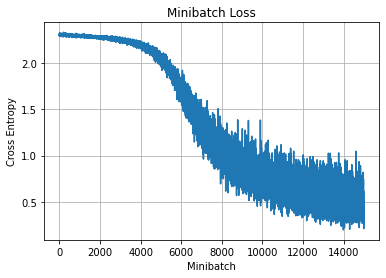

In [ ]:
plt.plot(range(len(minibatch_cost)), minibatch_cost)
plt.title('Minibatch Loss')
plt.ylabel('Cross Entropy')
plt.xlabel('Minibatch')
plt.grid()
plt.show()

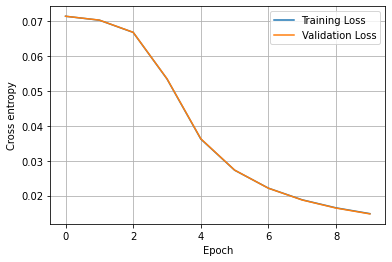

In [ ]:
plt.plot(range(len(train_loss_lst)), train_loss_lst, label='Training Loss')
plt.plot(range(len(valid_loss_lst)), valid_loss_lst, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross entropy')
plt.xlabel('Epoch')
plt.grid()
plt.show()

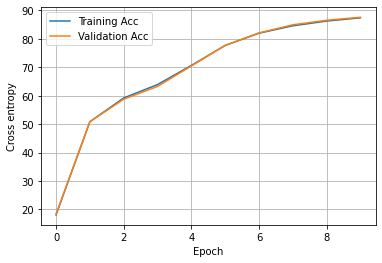

In [ ]:
plt.plot(range(len(train_acc_lst)), train_acc_lst, label='Training Acc')
plt.plot(range(len(valid_acc_lst)), valid_acc_lst, label='Validation Acc')
plt.legend(loc='upper left')
plt.ylabel('Cross entropy')
plt.xlabel('Epoch')
plt.grid()
plt.show()

We compute the accuracy on the test set as follows:

In [ ]:
#@title Fill Code

test_acc, test_loss = ...
print('Test accuracy: %.2f%%' % (test_acc))

Test accuracy: 88.01%


In [ ]:
#@title Solution

test_acc, test_loss = compute_accuracy_and_loss(model, test_loader, device)
print('Test accuracy: %.2f%%' % (test_acc))

In [ ]:
#@title Fill Code

# obtain one batch of test images
data_iter = ...
images, targets = ...

In [ ]:
#@title Solution

# obtain one batch of test images
data_iter = iter(test_loader)
images, targets = data_iter.next()

In [ ]:
#@title Fill Code

# get sample outputs
logits, probas = ...

# convert output probabilities to predicted class
_, preds = torch.max(probas, 1)

In [ ]:
#@title Solution

# get sample outputs
logits, probas = model(images.to(device))

# convert output probabilities to predicted class
_, preds = torch.max(probas, 1)

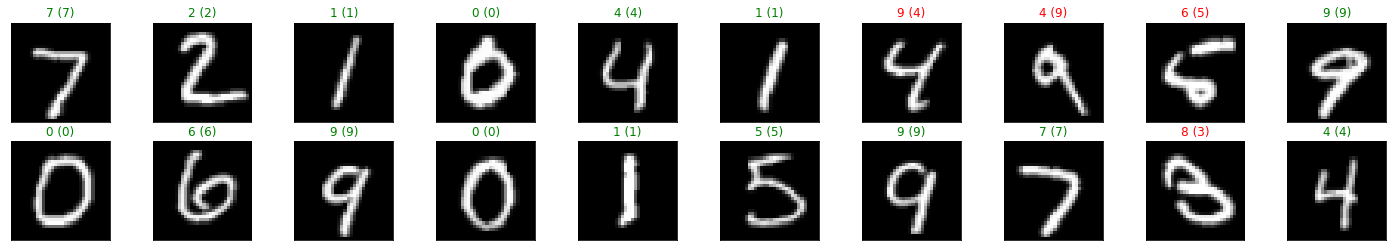

In [ ]:
# plot the images in the batch, along with predicted and true targets
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(targets[idx].item())),
                 color=("green" if preds[idx]==targets[idx] else "red"))

In [ ]:
#@title Fill Code

# calculate the confusion matrix
cm = ...
print(cm)

[[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 1 0]
 [0 0 0 0 4 0 0 0 0 1]
 [0 0 0 0 0 2 1 0 0 0]
 [0 0 0 0 1 0 2 0 0 0]
 [0 0 0 0 0 0 0 3 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 4]]


In [ ]:
#@title Solution

# calculating the confusion matrix
cm = confusion_matrix(targets.cpu(), preds.cpu())
print(cm)

/usr/local/lib/python3.7/dist-packages/scikitplot/metrics.py:124: RuntimeWarning: invalid value encountered in true_divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


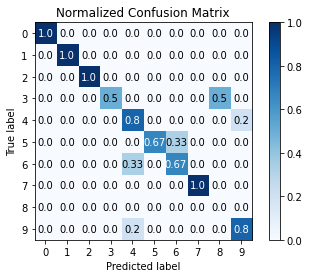

In [ ]:
#@title Fill Code

skplt.metrics.plot_confusion_matrix(..., ..., normalize=True)

In [ ]:
#@title Solution

skplt.metrics.plot_confusion_matrix(targets.cpu(),preds.cpu(), normalize=True)